# PyTorch Workflow

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.1+cu117'

## Prepare and Load Data

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and testing sets

In [3]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

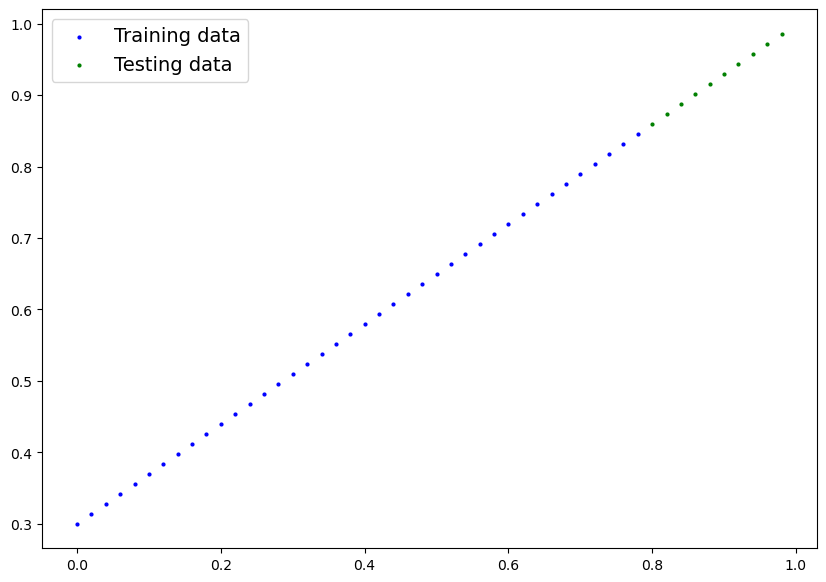

In [4]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})


plot_predictions()

## Build Model

In [5]:
# Linear Regression Model Class


class LinearRegressionModel(nn.Module):  # Base class for all Models: nn.Module
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [6]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [7]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Make Predictions (Untrained Model)

In [8]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

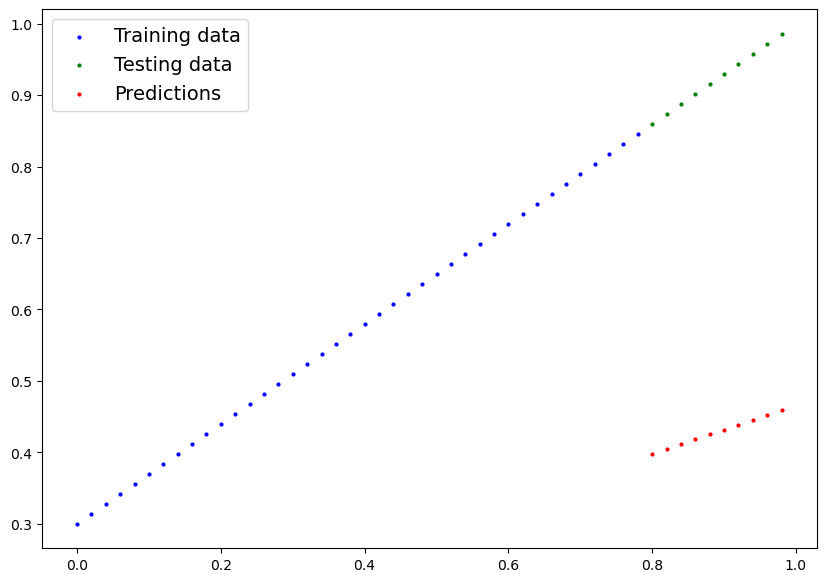

In [9]:
plot_predictions(predictions=y_preds)

## Train Model

In [10]:
# Loss function (Measure how wrong the model is)
loss_fn = nn.L1Loss()

# Optimizer (stochastic gradient descent)
# lr = how much to change the parameter
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Build a training loop

In [11]:
torch.manual_seed(42)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    # Set to training mode (keep track of gradients)
    model_0.train()

    # Forward Pass
    y_pred = model_0(X_train)

    # Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # Optimizer Zero Grad
    optimizer.zero_grad()

    # Backpropagation on the loss with respect to the model parameters
    loss.backward()

    # Step the optimizer (gradient descent) -> values acculumate, that's why we have the zero_grad() above
    optimizer.step()

    # Testing Loop
    # Turns off settings not needed for evaluation and testing
    model_0.eval()
    with torch.inference_mode():
        test_preds = model_0(X_test)

        test_loss = loss_fn(test_preds, y_test)

    if epoch % 10 == 0:

        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())

        print(f"Epoch: {epoch} | Loss: {loss} | Test loss {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

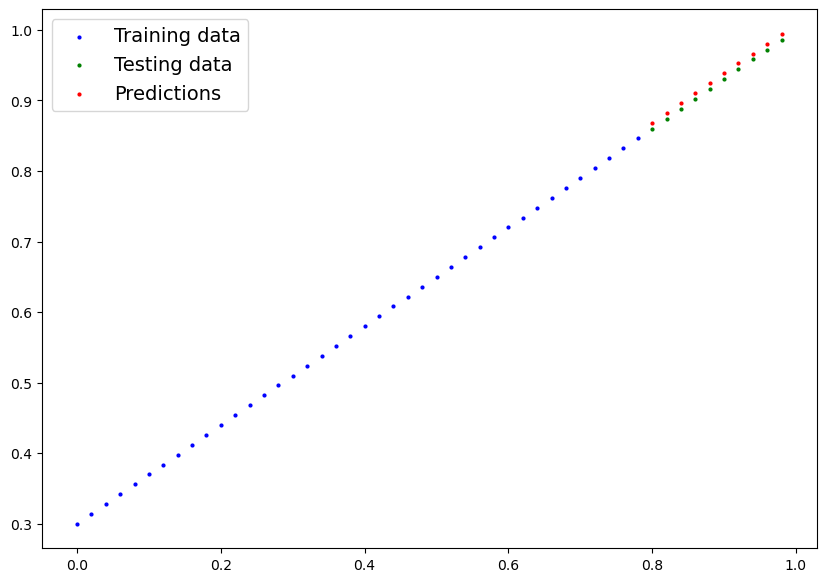

In [12]:
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

## Evaluate the Model

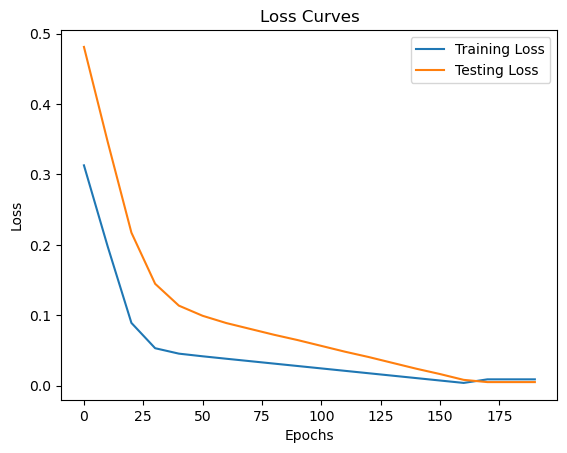

In [13]:
plt.plot(epoch_count, loss_values, label="Training Loss")
plt.plot(epoch_count, test_loss_values, label="Testing Loss")

plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Save the model

In [27]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [28]:
model_1 = LinearRegressionModel()
state_dict = torch.load(MODEL_SAVE_PATH)
model_1.load_state_dict(state_dict)

model_1.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
model_1.eval()

with torch.inference_mode():
    model_1_preds = model_1(X_test)

model_1_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [31]:
y_preds == model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting it all together

In [33]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.1+cu117'

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cuda')

In [88]:
weight = 0.1
bias = 0.333

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1).to(device)
y = weight * X + bias

X, y

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800],
         [0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]], device='cuda:0'),
 tensor([[0.3330],
         [0.

In [89]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

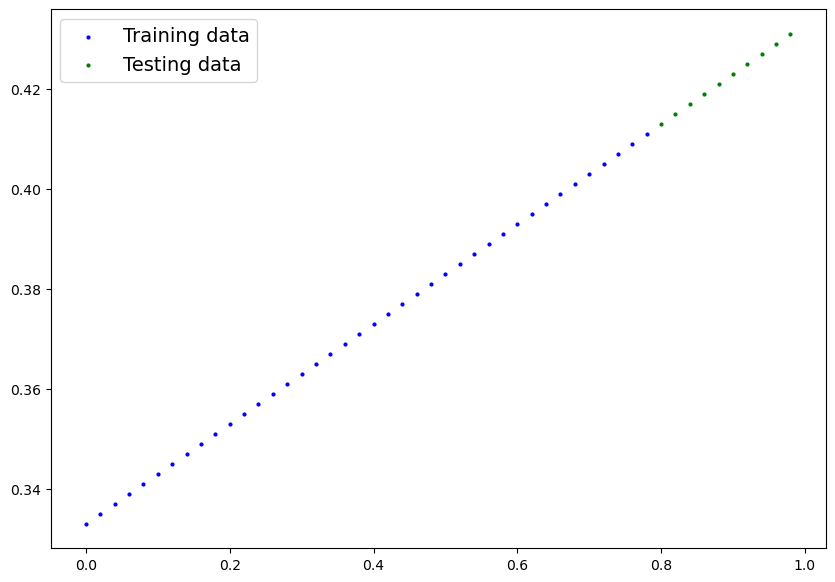

In [91]:
plot_predictions(X_train.to("cpu"), y_train.to("cpu"), X_test.to("cpu"), y_test.to("cpu"))

In [103]:
class LinearRegressionModel2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # self.weight = nn.Parameter(torch.randn(1))
        # self.bias = nn.Parameter(torch.randn(1))
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(100)    
model_2 = LinearRegressionModel2()

model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.7767]])),
             ('linear_layer.bias', tensor([0.6317]))])

In [104]:
model_2.to(device)

model_2

LinearRegressionModel2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [105]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters() ,lr=0.001)

optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}

Epoch: 0 | Loss: 0.17790250480175018 | Test loss: 0.4812404215335846
Epoch: 10 | Loss: 0.17724083364009857 | Test loss: 0.4781310558319092
Epoch: 20 | Loss: 0.17657913267612457 | Test loss: 0.47502169013023376
Epoch: 30 | Loss: 0.17591746151447296 | Test loss: 0.47191235423088074
Epoch: 40 | Loss: 0.17525579035282135 | Test loss: 0.4688029885292053
Epoch: 50 | Loss: 0.17459411919116974 | Test loss: 0.4656936228275299
Epoch: 60 | Loss: 0.17393244802951813 | Test loss: 0.4625842571258545
Epoch: 70 | Loss: 0.17327074706554413 | Test loss: 0.4594748914241791
Epoch: 80 | Loss: 0.17260907590389252 | Test loss: 0.45636555552482605
Epoch: 90 | Loss: 0.1719474047422409 | Test loss: 0.453256219625473
Epoch: 100 | Loss: 0.17141814529895782 | Test loss: 0.45074111223220825
Epoch: 110 | Loss: 0.17091356217861176 | Test loss: 0.4482920169830322
Epoch: 120 | Loss: 0.1704089641571045 | Test loss: 0.4458429515361786
Epoch: 130 | Loss: 0.16990438103675842 | Test loss: 0.44339391589164734
Epoch: 140 | Lo

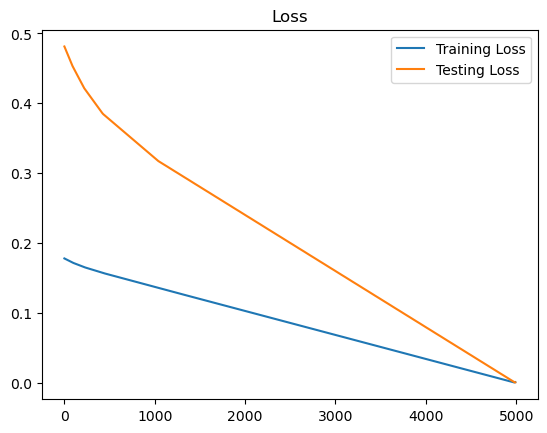

In [106]:
torch.manual_seed(100)

epoch_count = 5000
epochs = []
loss_values = []
test_loss_values = []

for epoch in range(epoch_count):
    model_2.train()

    y_pred = model_2(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()

    with torch.inference_mode():
        test_pred = model_2(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        epochs.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())

plt.plot(epochs, loss_values, label="Training Loss")
plt.plot(epochs, test_loss_values, label="Testing Loss")
plt.title("Loss")
plt.legend()

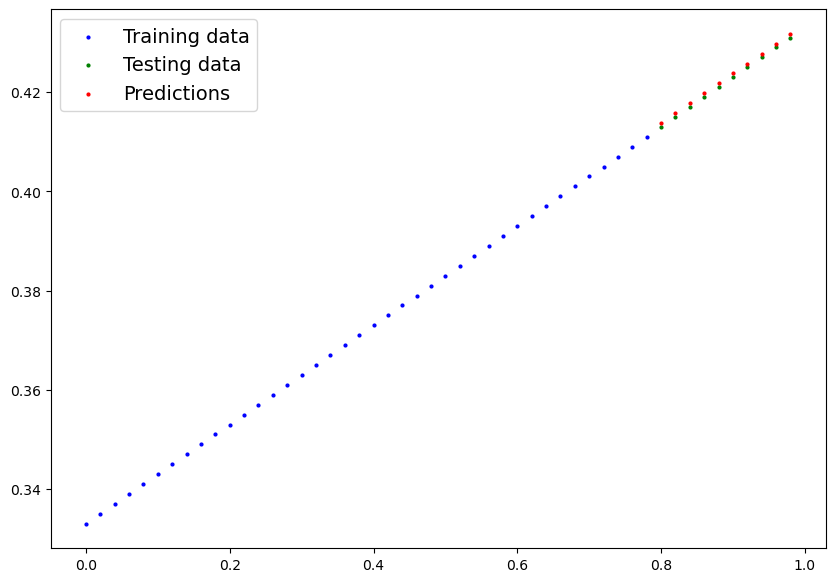

In [118]:
model_2.eval()
with torch.inference_mode():
    y_pred = model_2(X_test)

plot_predictions(
    X_train.to("cpu"),
    y_train.to("cpu"),
    X_test.to("cpu"),
    y_test.to("cpu"),
    y_pred.to("cpu"),
)

In [114]:
from pathlib import Path

MODEL_PATH = Path("models")
Path.mkdir(MODEL_PATH, parents=True, exist_ok=True)
MODEL_NAME = "01_model_2.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_2.state_dict(), MODEL_SAVE_PATH)

In [119]:
model_2_2 = LinearRegressionModel2()

model_2_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_2_2.state_dict()
model_2_2.to(device)

LinearRegressionModel2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [120]:
(weight, bias)

(0.1, 0.333)

In [125]:
next(model_2_2.parameters()).device

device(type='cuda', index=0)

In [127]:
model_2_2.eval()

with torch.inference_mode():
    model_2_preds = model_2_2(X_train)

model_2_preds

tensor([[0.3339],
        [0.3359],
        [0.3379],
        [0.3399],
        [0.3419],
        [0.3439],
        [0.3459],
        [0.3479],
        [0.3499],
        [0.3519],
        [0.3539],
        [0.3559],
        [0.3579],
        [0.3599],
        [0.3619],
        [0.3639],
        [0.3658],
        [0.3678],
        [0.3698],
        [0.3718],
        [0.3738],
        [0.3758],
        [0.3778],
        [0.3798],
        [0.3818],
        [0.3838],
        [0.3858],
        [0.3878],
        [0.3898],
        [0.3918],
        [0.3938],
        [0.3958],
        [0.3978],
        [0.3998],
        [0.4018],
        [0.4038],
        [0.4058],
        [0.4078],
        [0.4098],
        [0.4118]], device='cuda:0')